# Figure list for general exam report


In [3]:
dir = "/nobackup1/hdrake/pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT
#@pyimport gsw # documentation at https://teos-10.github.io/GSW-Python/

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 75;

# Numerical model configuration

In [4]:
N = sqrt(1.5)*1.e-3
#layer_scale = mean(exp.(-((2500:100:5000)+z0)/1000)) # average of exponential decay of abyssal layer
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

#topo_col = (21./255.,30./255.,68./255.)
topo_col = (0.75,0.75,0.80)


filepath = "../data/raw/woce_global_hydrographic_climatology/wghc_params.nc"
depth = -ncread(filepath,"ZAX")[:]
depth = reshape(depth,(1,1,size(depth)[1]))
gamman = ncread(filepath,"GAMMAN")[:,:,:];

gamman[gamman .<= 0.] .= NaN
lon = ncread(filepath,"LON")
lon = reshape(lon,(size(lon)[1],1,1))
lat = ncread(filepath,"LAT");
lat = reshape(lat,(1,size(lat)[1],1));

N2 = -(gamman[:,:,2:end].-gamman[:,:,1:end-1])./(depth[:,:,2:end].-depth[:,:,1:end-1])*9.81/(1020.);

depth_N2 = (depth[:,:,2:end].+depth[:,:,1:end-1])/2.;

lat_min = -55; lat_max = -45; lon_min = 175; lon_max = 245;

mm,lat_min_idx = findmin(abs.(lat[1,:,1] .- lat_min))
mm,lat_max_idx = findmin(abs.(lat[1,:,1] .- lat_max))
mm,lon_min_idx = findmin(abs.(lon[:,1,1] .- lon_min))
mm,lon_max_idx = findmin(abs.(lon[:,1,1] .- lon_max))

N2av = nanmean(N2[lon_min_idx:lon_max_idx,lat_min_idx:lat_max_idx,:], [1,2]);

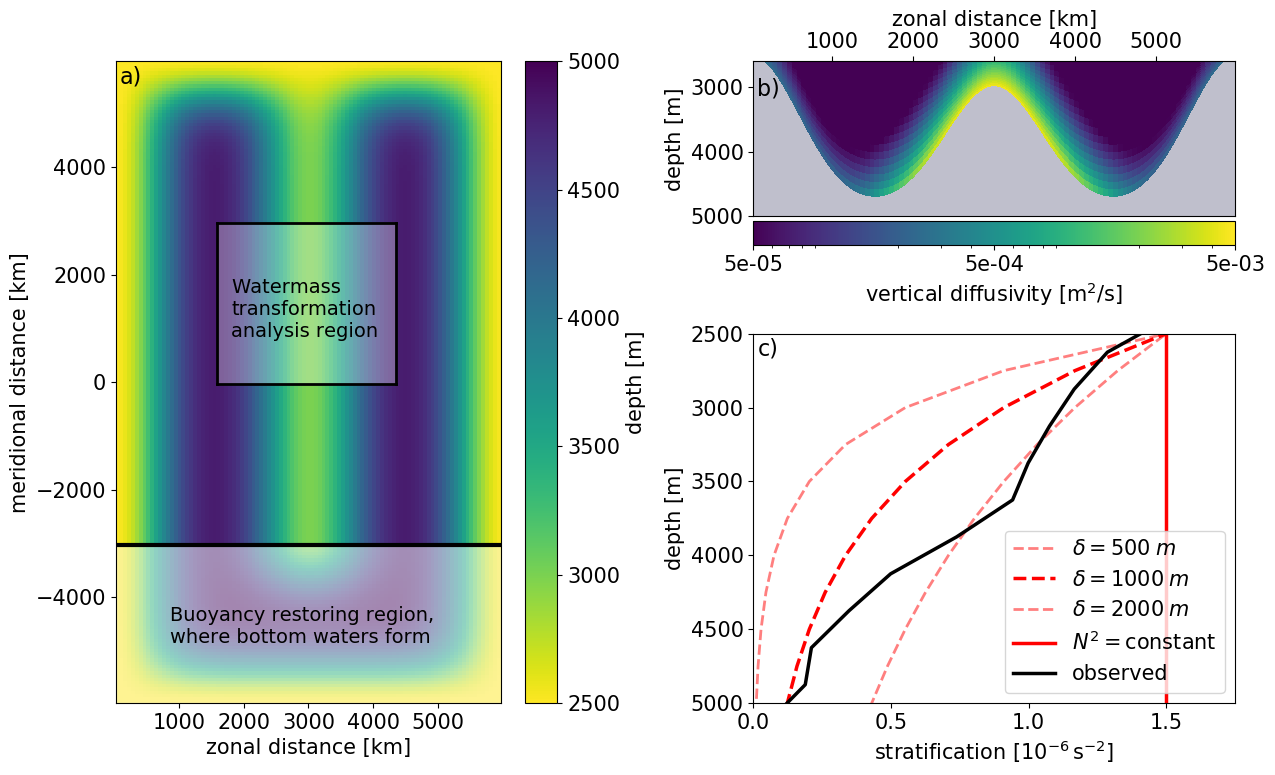

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[34]:52
└ @ Core In[34]:52
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[34]:52
└ @ Core In[34]:52


In [34]:
#### Fig 2

figure(figsize=(13,8))
PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;

lati = 150
cmap=get_cmap("RdBu_r")
vcmap=get_cmap("viridis_r")
expname = "src_kappa-bottom_ridge-0.8_del-0.4";

#include(string(dir,expname,"/runs/equil/kernel.jl"))
include("../src/kernel.jl");

lati = 150 # latitude of transect
loni = 50 # longitude of transect

m = load(string(dir,expname,"/runs/equil")) # Model setup

hc = [m.hc[1,j,i] for k in 1:length(m.sf), j in 1:length(m.yc), i in 1:length(m.xc)];
kridgeav = sum((m.kfs.*ones(size(m.hc))).*(m.hc.*m.ds.*ones(size(hc)))*m.dx*m.dy)./sum((m.hc.*m.ds.*ones(size(hc)))*m.dx*m.dy)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

dep = -((sc).*hc)*H .+Htop

ax1 = subplot2grid((8, 8), (0, 0), rowspan = 8, colspan=4)
cp = pcolor(xc[1,:,:]*L*1e-3,yc[1,:,:]*L*1.e-3,hc[1,:,:]*H .+Htop,cmap=vcmap)
colorbar(label="depth [m]")
clim([Htop.+H, Htop])
fill_between(xc[1,50,:]*L*1.e-3, yc[1,1,:]*L*1.e-3, yc[1,50,:]*L*1.e-3, color="w",alpha=0.5)
ylabel("meridional distance [km]")
xlabel("zonal distance [km]")
annotate(s="a)",xy=(0.01,0.965),xycoords="axes fraction",fontsize=16)

plot(xc[1,50,:]*L*1.e-3,yc[1,50,:]*L*1.e-3,"-",lw=3,color="k")
annotate(s="Buoyancy restoring region,\nwhere bottom waters form",xy=(0.14,0.093),xycoords="axes fraction",color="k",fontsize=14)

fill_between([xc[1,1,27],xc[1,1,73]]*L*1.e-3,[yc[1,100,1],yc[1,100,1]]*L*1.e-3,[yc[1,150,1],yc[1,150,1]]*L*1.e-3,color="w",alpha=0.3)
plot(xc[1,100:150,27]*L*1.e-3,yc[1,100:150,27]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,100,27:73]*L*1.e-3,yc[1,100,27:73]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,100:150,73]*L*1.e-3,yc[1,100:150,73]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,150,27:73]*L*1.e-3,yc[1,150,27:73]*L*1.e-3,"-",lw=2,color="k")
annotate(s="Watermass\ntransformation\nanalysis region",xy=(0.30,0.57),xycoords="axes fraction",color="k",fontsize=14)

ax2 = subplot2grid((8, 8), (0, 4), rowspan = 3, colspan=4)
ax = gca()
ax.set_facecolor(topo_col)
cp = pcolor(xc[2:end,lati,:]*L*1.e-3,-(m.sf.*m.hc)[:,lati,:]*H .+Htop,(m.kfs.*ones(size(m.hc)))[:,lati,:]*kscale,
    cmap=get_cmap("viridis"), norm=matplotlib[:colors][:LogNorm](vmin=5e-5, vmax=5e-3))
ylabel("depth [m]")
ax2.xaxis.tick_top()
ax2.set_xlabel("zonal distance [km]")
ax2.xaxis.set_label_position("top")
cb = colorbar(label=L"vertical diffusivity [m$^{2}$/s]",orientation="horizontal",
    pad=0.025, ticks =[5e-5,5e-4,5e-3], format="%.0e")
ylim([H.+Htop, Htop.+100])
annotate(s="b)",xy=(0.0085,0.78),xycoords="axes fraction",fontsize=16)

ax3 = subplot2grid((8, 8), (3, 4), rowspan = 5, colspan=4)
z0=-Htop
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/500)*1e6,-depth[1,1,:],"r--",lw=2.,label=L"$\delta=500\; m$",alpha=0.5)
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/1000)*1e6,-depth[1,1,:],"r--",lw=2.5,label=L"$\delta=1000\; m$")
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/2000)*1e6,-depth[1,1,:],"r--",lw=2.,label=L"$\delta=2000\; m$",alpha=0.5)
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/1e20)*1e6,-depth[1,1,:],"r-",lw=2.5,label=L"$N^{2}=$constant")
plot(N2av[1,1,:]*1.e6,-depth_N2[1,1,:],"k",lw=2.5, label="observed")
ylim([Htop+H, Htop])
xlim([-5e-10*1e6, 1.75e-6*1e6])
xlabel(L"stratification $[10^{-6} \, $s$^{-2}]$")
ylabel("depth [m]")
legend(loc=4)
annotate(s="c)",xy=(0.01,0.94),xycoords="axes fraction",fontsize=16)

tight_layout()

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/model_setup.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium circulation

In [36]:
expname = "src_kappa-bottom_ridge-0.8_del-0.4"
nIter = 40000*50

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc;

Nsq = dscc(m,s.bc,0.)./m.hc;

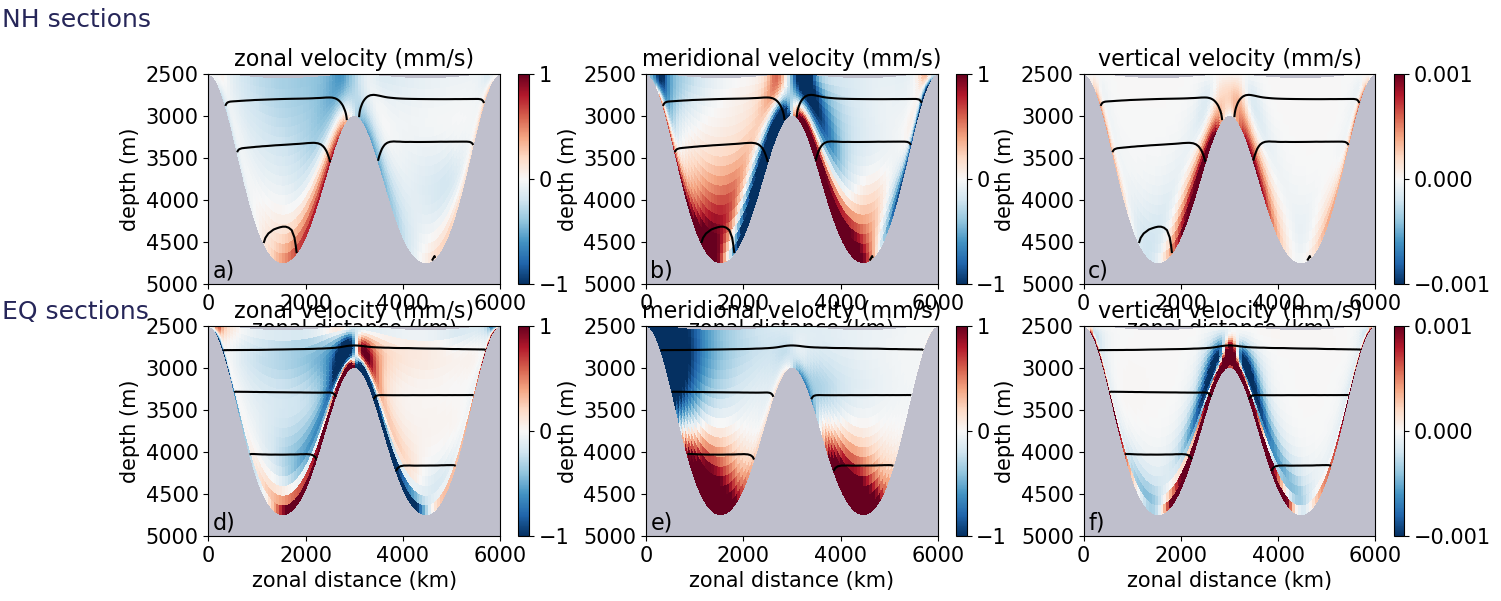

In [45]:
figure(figsize=(16,6))
xy = (0.015,0.03)

lati = 150
subplot(2,3,1)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uxc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("zonal velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="a)",xy=xy,xycoords="axes fraction",fontsize=16)


subplot(2,3,2)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uyc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("meridional velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="b)",xy=xy,xycoords="axes fraction",fontsize=16)

subplot(2,3,3)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-0.001,0,0.001])
clim([-0.001,0.001])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("vertical velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="c)",xy=xy,xycoords="axes fraction",fontsize=16)

lati = 100

subplot(2,3,4)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uxc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("zonal velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="d)",xy=xy,xycoords="axes fraction",fontsize=16)


subplot(2,3,5)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uyc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("meridional velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="e)",xy=xy,xycoords="axes fraction",fontsize=16)

subplot(2,3,6)
ax = gca()
ax.set_facecolor(topo_col)
cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=cmap)
colorbar(ticks=[-0.001,0,0.001])
clim([-0.001,0.001])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("vertical velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="f)",xy=xy,xycoords="axes fraction",fontsize=16)

annotate(s="NH sections",xy=(0.001,0.955),xycoords="figure fraction",color=(0.15,0.15,0.35),fontsize=18)
annotate(s="EQ sections",xy=(0.001,0.47),xycoords="figure fraction",color=(0.15,0.15,0.35),fontsize=18)

tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/velocity.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium meridional overturning streamfunctions

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expname = "src_kappa-bottom_ridge-0.8_del-0.4"

blevel = [-0.824,-0.624,-0.424,-0.224]

maxT = 2
dT = 0.2
nf = 150
del = 1.
nIter = 40000*50

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

# Plotting Parameters
lati = 150 # latitude of transect
loni = 25
lonridge = 50

cmap=get_cmap("RdBu_r")
PyCall.PyDict(matplotlib["rcParams"])["figure.figsize"] = 10, 5
PyCall.PyDict(matplotlib["rcParams"])["contour.negative_linestyle"] = "solid"

#------------------------  Load  Model data  ------------------------------

include(string(dir,expname,"/runs/equil/kernel.jl"))
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

tht = -atan.(m.hxc)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

b0 = m.bic

#------------------------  Calculate Psi(y,z) ------------------------------
mins = -1.
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

itp = interpolate((m.sc[:,1,1], m.yf[1,:,1], m.xc[1,1,:]), uy, Gridded(Linear()));
uyf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]];

psi = zeros(nf, m.ny-1)
zf = zeros(nf, m.ny-1)
bpsi = zeros(nf, m.ny-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uyf.*m.hfy,(1,3))*m.dy*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfy, (1, 3))./sum(idx, (1, 3))
    bpsi[i,:] = (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] = -1.
zf=sort(zf,1);

yp,bp = 
[m.yf[i] for k in 1:length(bf), i in 1:length(m.yf)],
[bf[k] for k in 1:length(bf), j in 1:length(m.yf)];

ypz,zpz = 
[m.yf[i] for k in 1:length(zf[:,1]), i in 1:length(m.yf)],
[zf[k,j] for k in 1:length(zf[:,1]), j in 1:length(m.yf)];

hpz = [m.hfy[1,j,50] for k in 1:nf, j in 1:length(m.yf)];
bpsi[zpz.<-hpz] = NaN

y_yz = copy(ypz)
z_yz = copy(zpz)
psi_yz = copy(psi)

#------------------------  Calculate Psi(X,Z) ------------------------------

mins = -1.
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xf[1,1,:]), ux, Gridded(Linear()));
uxf = itp[sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]];

psi = zeros(nf, m.nx-1)
zf = zeros(nf, m.nx-1)
bpsi = zeros(nf, m.nx-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uxf.*m.hfx,(1,2))*m.dx*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfx, (1, 2))./sum(idx, (1, 2))
    bpsi[i,:] = (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] = -1.
zf=sort(zf,1);

xp,bp = 
[m.xf[i] for k in 1:length(bf), i in 1:length(m.xf)],
[bf[k] for k in 1:length(bf), i in 1:length(m.xf)];

xpz,zpz = 
[m.xf[i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)],
[zf[k,i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)];

hpz = [m.hfx[1,100,i] for k in 1:nf, i in 1:length(m.xf)];
bpsi[zpz.<-hpz] = NaN

psi_xz = copy(psi)
x_xz = copy(xpz)
z_xz = copy(zpz)

#------------------------  Calculate Psi(X,Y) ------------------------------

U,V = squeeze(sum(uxc.*m.ds.*m.hc,1),1), squeeze(sum(uyc.*m.ds.*m.hc,1),1)

psi_xy = cumsum(V,2)*m.dx;


In [ ]:
fig = figure(figsize=(14,9))
gridspec = matplotlib[:gridspec]
gs = gridspec[:GridSpec](
    2, 2,
    width_ratios=[3, 1],
    height_ratios=[1, 2.5]
)

levels = -maxT:dT:maxT

lonridge = 50
loni = 25
latridge = 160
latdeepest = 26

ax1 = subplot(gs[1])
cf = contourf(y_yz*L*1.e-3,z_yz*(-H)+Htop,psi_yz*Tscale,cmap=cmap,levels=levels,extend="both")
ct = contour(yc[:,:,loni]*L*1.e-3,(sc.*hc)[:,:,loni]*(-H)+Htop,s.bc[:,:,loni],5,colors="k",linestyles="solid",linewidths=1)
fill_between(yc[1,:,loni]*L*1.e-3,zeros(hc[1,:,loni])+6000,-hc[1,:,loni]*(-H)+Htop,color=topo_col)
plot(yc[1,:,lonridge]*L*1.e-3,-hc[1,:,lonridge]*(-H)+Htop,color="brown",lw=3.)
xlim([-L*1.e-3*0.98,L*1.e-3*0.98])
ylim([(H+Htop)*0.98,Htop])
yticks([5000,4000,3000])
ylabel("depth [m]")
title("meridional overturning")
annotate(s="a)",xy=(0.0075,0.045),xycoords="axes fraction",fontsize=18)

ax2 = fig[:add_axes]([0.755,0.84,0.22,0.04])
colorbar(cf,cax=ax2,ticks=-maxT:dT*5:maxT,orientation="horizontal",label="streamfunction [Sv]")

ax3 = subplot(gs[3])
ax = gca()
ax["set_facecolor"](topo_col)
psi_xy[m.hc[1,:,:].<0.196] = NaN
contourf(yc[1,:,:]*L*1.e-3,xc[1,:,:]*L*1.e-3,psi_xy*Tscale,cmap=cmap,levels=levels)
ct = contour(yc[1,:,:]*L*1.e-3,xc[1,:,:]*L*1.e-3,hc[1,:,:]*H+Htop,levels=[3000,4000],colors="k",linestyles="solid",linewidths=3)
clabel(ct, inline=true, fontsize=12)
plot(yc[1,latridge,:]*L*1.e-3,xc[1,latridge,:]*L*1.e-3,color="midnightblue",lw=3.,linestyle="--",alpha=0.6)
plot(yc[1,:,lonridge]*L*1.e-3,xc[1,:,lonridge]*L*1.e-3,color="brown",lw=3.,linestyle="--",alpha=0.6)
ylim([L*1.e-3*0.98,L*1.e-3*0.02])
xlim([-L*1.e-3*0.98,L*1.e-3*0.98])
xlabel("meridional distance [km]");
ylabel("zonal distance [km]");
title("barotropic circulation")
annotate(s="b)",xy=(0.0075,0.945),xycoords="axes fraction",fontsize=18)

ax4 = subplot(gs[4])
contourf(z_xz*(-H)+Htop,x_xz*L*1.e-3,psi_xz*Tscale,cmap=cmap,levels=levels)
ct = contour((sc.*hc)[:,lati,:]*(-H)+Htop,xc[:,lati,:]*L*1.e-3,s.bc[:,lati,:],5,colors="k",linestyles="solid",linewidths=1)
fill_betweenx(xc[1,latdeepest,:]*L*1.e-3,zeros(hc[1,latdeepest,:])+6000,-hc[1,latdeepest,:]*(-H)+Htop,color=topo_col)
plot(-hc[1,latridge,:]*(-H)+Htop,xc[1,latridge,:]*L*1.e-3,color="midnightblue",lw=3.)
ylim([L*1.e-3*0.98,L*1.e-3*0.02])
yticks([])
xlim([(H+Htop)*0.98,Htop])
xticks([4000,3000])
xlabel("depth [m]")
title("zonal overturning")
annotate(s="c)",xy=(0.02,0.945),xycoords="axes fraction",fontsize=18)

tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/streamfunctions.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
figure(figsize=(15,7))
panel_label=["a)","b)","c)","d)"]
xy = (0.01,0.03)

iplot=1
for nIter = [40000*0.1,40000*50]
    expname = "src_kappa-bottom_ridge-0.8_a-0.0"

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc;


    file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
    bc = read(file, "bc")-m.bic;

    tht = -atan.(m.hxc)
    r = 0.1; # friction coefficie-atan.(m.hxc)nt
    a = 0.2; # aspect ratio
    # 1D prediction velocities in rotated coordinates
    uxr = r.*tan.(tht).^2./((r^2.+m.yc.^2).*sin.(tht)).*bc
    uyr = (-m.yc.*cos.(tht)/r).*uxr
    uzr = uxr*0.

    ux = uxr.*cos.(tht)-uzr.*sin.(tht);
    uy = uyr
    uz = uzr.*cos.(tht)+uxr.*sin.(tht);

    lati = 150

    subplot(2,2,1+(iplot-1)*2)
    ax = gca()
    ax["set_facecolor"](topo_col)
    cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uz[:,lati,:],cmap=get_cmap("RdBu_r"))
    colorbar(ticks=[-0.001,0,0.001],label="vertical velocity (mm/s)")
    clim([-0.001,0.001])
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],(bc+m.bic)[:,lati,:],levels=-1.075:0.25:0, colors="k",linestyles="solid")
    xlabel("zonal distance (km)")
    ylabel("depth (m)")
    title(string("1D Emulator ",L"($\hat{t} = $",round(nIter/40000.,1),")"),fontsize=16)
    xlim([0.27,0.73]*L*1e-3)
    ylim([5000,2550])
    annotate(s=panel_label[1+(iplot-1)*2],xy=xy,xycoords="axes fraction",fontsize=16)

    subplot(2,2,2+(iplot-1)*2)
    ax = gca()
    ax["set_facecolor"](topo_col)
    cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=get_cmap("RdBu_r"))
    colorbar(ticks=[-0.001,0,0.001],label="vertical velocity (mm/s)")
    clim([-0.001,0.001])
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],(bc+m.bic)[:,lati,:],levels=-1.075:0.25:0, colors="grey",linestyles="dashed")
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.25:0, colors="k",linestyles="solid")
    xlabel("zonal distance (km)")
    ylabel("depth (m)")
    title(string("3D PGCM ",L"($\hat{t} = $",round(nIter/40000.,1),")"),fontsize=16)
    xlim([0.27,0.73]*L*1e-3)
    ylim([5000,2550])
    annotate(s=panel_label[2+(iplot-1)*2],xy=xy,xycoords="axes fraction",fontsize=16)

    iplot+=1
end
tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/compare_1d_3d.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium watermass transformations

The total watermass transformations are given by
\begin{equation}
T 
= \frac{\partial}{\partial \gamma} \int_{\gamma'>\gamma} \nabla \cdot (\kappa \nabla \gamma') \; dV
\approx \frac{\partial}{\partial \gamma} \int_{\gamma'>\gamma} \partial_{z} (\kappa \partial_{z} \gamma') \; dV
\end{equation}

In [ ]:
file = matopen("/nobackup1/hdrake/data/buoyancy_flux/4Henri_with_bkg_K.mat")
names(file) 
# This gives an error, but it seems that it can be ignored and otherwise works as intentded...

In [ ]:

names(file);
varnames = file.varnames;

rho0 = 1020.
g = 9.81

lon = -180.:1.:179.
lat = -74.:1.:63.
dA = read(file, "CA");
pres = read(file, "P");

dep = read(file, "bathy");
Gamma = read(file, "Gamma");

gamma = read(file, "D");

pres_f = read(file, "P1");
dpres_c = pres_f[2:end] - pres_f[1:end-1]
wb_f = read(file, "WB"); # wb_f = -kappa_f.*N2_f
N2_f = read(file, "N2");
gamma_f = read(file, "D1");
kappa_f = read(file, "Kv"); # kappa_f = -wb_f./N2_f
wbbg_f = read(file, "bgflux");

interp_f_to_c(field_f) = (field_f[:,:,2:end].+field_f[:,:,1:end-1])/2.
divergence(wb_f) = (wb_f[:,:,1:end-1].-wb_f[:,:,2:end])./reshape(dpres_c, (1,1,size(dpres_c)...))

N2_av = nanmean(N2_f,[1,2])
N2_f[isnan.(N2_f)] = 0.
kappa_f[isnan.(kappa_f)] = 0.
kappa_f[kappa_f.>1.e-1] = 1.e-1
wb_f[isnan.(wb_f)] = 0.

dV = reshape(dpres_c, (1,1,size(dpres_c)...)).*reshape(dA, (size(dA)...,1))

pres_c = (pres_f[1:end-1]+pres_f[2:end])/2.
gamma_c = gamma[:,:,2:end-1]

fluxdiv_c = divergence(wb_f)*(-rho0/g);

find_zero_index(array,j,i) = findmax(array[j,i,:].==0.)[2]
bbl_idx = [
    find_zero_index(fluxdiv_c,j,i)-1==k
    for j=1:size(fluxdiv_c,1), i=1:size(fluxdiv_c,2), k=1:size(fluxdiv_c,3)
    ]

fluxdiv_varN_c = -interp_f_to_c(kappa_f).*divergence(N2_f)*(-rho0/g);
fluxdiv_vark_c = -interp_f_to_c(N2_f).*divergence(kappa_f)*(-rho0/g);

fluxdiv_bbl_c = copy(fluxdiv_c); fluxdiv_bbl_c[.~bbl_idx] = 0.
fluxdiv_sml_c = copy(fluxdiv_c); fluxdiv_sml_c[bbl_idx] = 0.

dgamma_lev = 0.02
gamma_lev = 28.0-dgamma_lev:dgamma_lev:28.3+dgamma_lev
intfluxdiv_c = zeros(gamma_lev);

fluxdivs = [fluxdiv_c,fluxdiv_bbl_c,fluxdiv_sml_c]
colors = ["k","r","b"]

lat_2d = repeat(lat,1,length(lon))
lon_2d = permutedims(repeat(lon, 1, length(lat)),[2,1])

A_coords = [-26,-40,25,30]
I_coords = [55,-25,25,30]
P_coords = [-126,-40,25,30]

z_3d = permutedims(repeat(-pres_c,1,size(fluxdiv_c,1),size(fluxdiv_c,2)),[2,3,1]);

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expname = "src_kappa-bottom_ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter = 40000*50

nf = 40
del = 3

figure(figsize=(16,8))

short_name = L"$\hat{\delta} = 0.4$"

#------------------------  Load 3d Model data  ------------------------------

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(s.bc)
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(s.bc)
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(s.bc)
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(s.bc)
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Buoyancy tendency 
s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
dbdt = (s1.bc-s.bc)/(m.dt*4000.)

# Diagnose exact diffusive flux divergence as residual of other explicit terms
Dk = dbdt - (Du + Dr)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

x_fy,y_fy = 
[m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
[m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

###############    Water mass transformation     ##################
mins = -1.1
dsf = round(abs(mins/nf),5)
sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
end
zc[isnan.(zc)] = -1.

########################################
zref = vcat(copy(zc),[0])
bref = vcat(copy(bc)[:,1,1],[0])
nref = length(bref)
intD = zeros(bref)

BBLmask = Dk.>0.
for i=1:m.nx
    for j=1:m.ny
        BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
    end
end

labels = [
"Total",
"BBL",
"SML",
]

flux_list = [
Dk,
Dk,
Dk,
]

mask_list = [
trues(Dk),
BBLmask,
.~BBLmask
]

colors = [
"k",
"r",
"b",
]

linestyles = [
"-",
"-",
"-",
];

In [ ]:
fig = figure(figsize=(15,8))

ax1 = subplot2grid((4, 4), (0, 0), colspan=1, rowspan=2)
ax2 = subplot2grid((4, 4), (0, 1), colspan=1, rowspan=2)
ax3 = subplot2grid((4, 4), (0, 2), colspan=1, rowspan=2)
ax4 = subplot2grid((4, 4), (0, 3), colspan=1, rowspan=2)
ax5 = subplot2grid((4, 4), (2, 0), colspan=1, rowspan=2)
ax6 = subplot2grid((4, 4), (2, 1), colspan=3, rowspan=2)

ax = ax1
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(bref)
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] = 0

    ax[:set_title]("Simulated Ocean ridge",fontsize=16)
    ax[:plot](T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax[:set_xlim]([-3.,3.])
    ax[:set_xticks]([-3,-2,-1,0,1,2,3])
    ax[:set_ylim]([5000,2500])
    ax[:set_ylabel]("depth [m]")
    ax[:set_xlabel]("transformation rate [Sv]");

    ax[:grid](true);
end
ax[:annotate](s="a)",xy=(0.02,0.912),xycoords="axes fraction",fontsize=18)

panel_label = ["b)","c)","d)"]
coord_labels = ["Pacific Ocean ridge","Atlantic Ocean ridge", "Indian Ocean ridge"]
coords_list = [P_coords, A_coords, I_coords]
mask_depth_list = [3500,3900,4500]
axes = [ax2,ax3,ax4]
for f=1:length(fluxdivs)
    coord_idx=1
    for coords=coords_list
        ridge_mask = (
            (lon_2d.>coords[1]) .&
            (lat_2d.>coords[2]) .&
            (lon_2d.<coords[1]+coords[3]) .&
            (lat_2d.<coords[2]+coords[4])
        )
        
        ridge_mask_3d = repeat(ridge_mask,1,1,1)
        
        fluxdiv = fluxdivs[f]

        # Calculate WMT from buoyancy flux divergence
        for i=1:length(gamma_lev)
            idx = (gamma_c.>gamma_lev[i]) .& ridge_mask
            intfluxdiv_c[i] = sum((fluxdiv.*dV)[idx])
        end
        gamma_lev_f = (gamma_lev[1:end-1]+gamma_lev[2:end])/2.
        T = (intfluxdiv_c[1:end-1]-intfluxdiv_c[2:end])/dgamma_lev;
        
        # Find depth of mean buoyancy surface
        z_gamma_lev = zeros(length(gamma_lev))
        for i in 1:length(gamma_lev)
            idx = gamma_lev[i]-dgamma_lev/2. .< gamma_c .< gamma_lev[i]+dgamma_lev/2.
            z_gamma_lev[i] = sum(idx.*z_3d.*ridge_mask_3d)./sum(idx.*ridge_mask_3d)
        end
        z_gamma_lev[isnan.(z_gamma_lev)] = -5010.
        
        z_gamma_f = (z_gamma_lev[1:end-1]+z_gamma_lev[2:end])/2.
        
        ax = axes[coord_idx]
        
        # Plot WMT
        ax[:plot](T*1.e-6,-z_gamma_f,color=colors[f],label=labels[f])
        ax[:set_title](coord_labels[coord_idx],fontsize=16)
        ax[:set_ylim]([5000,2500])
        ax[:set_xlim]([-3.,3.])
        ax[:set_xticks]([-3,-2,-1,0,1,2,3])
        ax[:set_ylabel]("")
        ax[:set_yticklabels]([])
        ax[:set_xlabel]("transformation rate [Sv]")
        ax[:grid](true)
        ax[:fill_between]([-3,3],[5000,5000],[mask_depth_list[coord_idx],mask_depth_list[coord_idx]],alpha=1.0,facecolor=topo_col)
        if f==1; ax[:annotate](s=panel_label[coord_idx],xy=(0.02,0.912),xycoords="axes fraction",fontsize=18); end;
        if coord_idx==3; ax[:legend](loc="lower left", fontsize = 14); end;
        coord_idx+=1
    end
end

ax = ax5
ax[:set_facecolor](topo_col)

# Interpolate depth onto z-grid
knots = (m.sc[:],m.yc[:],m.xc[:]);
itp_Dk = interpolate(knots, Dk, Gridded(Linear()));

Dk_cart = zeros(Dk)

for i=1:m.nx
    for j=1:m.ny
        for k=1:m.ns
            if -m.sc[k]<m.hc[1,j,i]
                Dk_cart[k,j,i] = itp_Dk[m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
            else
                Dk_cart[k,j,i] = NaN
            end
        end
    end
end

pc = ax[:pcolor](xc[1,:,:]*L*1.e-3,yc[1,:,:]*L*1.e-3,Dk_cart[m.ns-8,:,:]*(N^2*kscale/H)*1.e13,cmap=get_cmap("RdBu_r"))
pc[:set_clim]([-5,5])
label_str = string(
    "buoyancy flux convergence\n",
    L"[10$^{-13}$ m s$^{-3}$]"
)

ax[:set_ylim]([-L*0.15e-3,L*0.65e-3])
ax[:set_xlim]([L*0.05e-3,L*0.95e-3])
ax[:set_xlabel]("zonal distance [km]")
ax[:set_ylabel]("meridional distance [km]")

ax[:add_patch](matplotlib[:patches][:Rectangle]((L*0.25e-3, 0.), L*0.5e-3, L*0.5e-3,
            edgecolor="k", linewidth=2.5, alpha=1, facecolor="none"))
ax[:annotate](s="e)",xy=(0.025,0.912),xycoords="axes fraction",fontsize=18)

#######
ax = ax6
ax[:set_facecolor](topo_col)


dep_idx = 33
fluxdiv_c_slice = copy(fluxdiv_c[:,:,dep_idx])
fluxdiv_c_slice[fluxdiv_c_slice.==0.] = NaN

pc = ax[:pcolor](lon,lat,fluxdiv_c_slice/(rho0/g)*1.e13,cmap=get_cmap("RdBu_r"))
pc[:set_clim]([-5,5])
label_str = string(
    "buoyancy flux convergence\n",
    L"[10$^{-13}$ m s$^{-3}$]"
)
cb = colorbar(pc,label=label_str)
ax[:set_title](" ")
ax[:set_ylim]([-50,15])
ax[:set_xlim]([-140,90])
ax[:set_xlabel]("longitude [degrees]")
ax[:set_ylabel]("latitude [degrees]")
ax[:annotate](s="f)",xy=(0.0075,0.912),xycoords="axes fraction",fontsize=18)

for coords=coords_list
    ax[:add_patch](matplotlib[:patches][:Rectangle]((coords[1], coords[2]), coords[3], coords[4],
            edgecolor="k", linewidth=2.5, alpha=1, facecolor="none"))
end

annotate(s=string("Buoyancy tendency due to turbulent mixing at ",Int(pres_c[dep_idx])," m"),xy=(0.0652,0.465),xycoords="figure fraction")


tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_compare_model_obs.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expname = "src_kappa-bottom_ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter = 40000*50

nf = 40
del = 3

figure(figsize=(16,8))

short_name = L"$\hat{\delta} = 0.4$"

#------------------------  Load 3d Model data  ------------------------------

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(s.bc)
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(s.bc)
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(s.bc)
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(s.bc)
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Buoyancy tendency 
s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
dbdt = (s1.bc-s.bc)/(m.dt*4000.)

# Diagnose exact diffusive flux divergence as residual of other explicit terms
Dk = dbdt - (Du + Dr)

# Explicit vertical flux divergence
hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
Dkz = zeros(s.bc)
Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);
sim_full_ridge_mask = (yc.>=0.) .& (xc.>0.25) .& (xc.<0.75);

x_fy,y_fy = 
[m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
[m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);
sim_full_ridge_mask_yf = (y_fy.>=0.) .& (x_fy.>0.25) .& (x_fy.<0.75);

###############    Water mass transformation     ##################
mins = -1.1
dsf = round(abs(mins/nf),5)
sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

zc_basin = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_basin[i] = sum(idx.*sf.*m.hfy.*(m.yf.>=0))./sum(idx.*(m.yf.>=0))
end
zc_basin[isnan.(zc_basin)] = -1.

zc_full = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_full[i] = sum(idx.*sf.*m.hfy.*sim_full_ridge_mask_yf)./sum(idx.*sim_full_ridge_mask_yf)
end
zc_full[isnan.(zc_full)] = -1.

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
end
zc[isnan.(zc)] = -1.


########################################
zref = vcat(copy(zc),[0])
zref_basin = vcat(copy(zc_basin),[0])
zref_full = vcat(copy(zc_full),[0])

bref = vcat(copy(bc)[:,1,1],[0])
nref = length(bref)
intD = zeros(bref)

BBLmask = Dk.>0.
for i=1:m.nx
    for j=1:m.ny
        BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
    end
end

labels = [
"Total",
"BBL",
"SML",
L"BBL$^{(z)}$",
L"SML$^{(z)}$"
]

flux_list = [
Dk,
Dk,
Dk,
Dkz,
Dkz
]

mask_list = [
trues(Dk),
BBLmask,
.~BBLmask,
BBLmask,
.~BBLmask
]

colors = [
"k",
"r",
"b",
"r",
"b"
]

linestyles = [
"-",
"-",
"-",
"--",
"--"
];

In [ ]:
fig = figure(figsize=(14,5))

ax = subplot(1,3,1)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(bref)
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& (m.yc.>=0)])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] = 0

    ax[:set_title]("Full NH Basin",fontsize=16)
    ax[:plot](T*Tscale,0.5*(zref_basin[1:end-1]+zref_basin[2:end])*(-H)+Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax[:set_xlim]([-3.,3.])
    ax[:set_xticks]([-3,-2,-1,0,1,2,3])
    ax[:set_ylim]([5000,2500])
    ax[:set_ylabel]("depth [m]")
    ax[:set_xlabel]("transformation rate [Sv]");

    ax[:grid](true);
end
ax[:annotate](s="a)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)


ax = subplot(1,3,2)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(bref)
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_full_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] = 0

    ax[:set_title]("Full NH Mid-Ocean Ridge",fontsize=16)
    ax[:plot](T*Tscale,0.5*(zref_full[1:end-1]+zref_full[2:end])*(-H)+Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax[:set_xlim]([-3.,3.])
    ax[:set_xticks]([-3,-2,-1,0,1,2,3])
    ax[:set_ylim]([5000,2500])
    ax[:set_ylabel]("depth [m]")
    ax[:set_xlabel]("transformation rate [Sv]");

    ax[:grid](true);
end
ax[:annotate](s="b)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)

ax = subplot(1,3,3)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(bref)
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] = 0

    
    ax[:plot](T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx],label=labels[flux_idx])
end
ax[:set_title]("Limited Mid-Ocean Ridge",fontsize=16)
ax[:set_xlim]([-3.,3.])
ax[:set_xticks]([-3,-2,-1,0,1,2,3])
ax[:set_ylim]([5000,2500])
ax[:set_ylabel]("depth [m]")
ax[:set_xlabel]("transformation rate [Sv]");
ax[:grid](true);
ax[:legend](loc="lower left",fontsize=15)
ax[:annotate](s="c)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)

tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expnames = ["src_kappa-bottom_ridge-0.8_a-0.0","src_kappa-bottom_ridge-0.8_del-0.4","src_kappa-bottom_ridge-0.8_del-0.2"]

include(string(dir,expnames[1],"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter_list = [4000,40000*50]

nfs = [22,50,60]
dels = [100,1.2,0.6]

figure(figsize=(16,8))

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m",L"$\delta = 500$ m"]

for t_idx = 1:length(nIter_list)
    nIter = nIter_list[t_idx]
    for ex = 1:length(expnames)
        expname = expnames[ex]
        nf = nfs[ex]

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(s.bc)
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(s.bc)
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(s.bc)
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(s.bc)
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*4000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        del = dels[ex]
        bf = del*(exp.(sf/del)-1)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del)-1)
        dbc = bc[2:end]-bc[1:end-1]

        itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
        bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

        
        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] = -1.
        
        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(bref)

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
            end
        end

        ######### DIFFUSIVE FLUXES ###########
        
        # Explicit vertical flux divergence
        hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
        Dkz = zeros(s.bc)
        Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        
        Dkbg = zeros(s.bc)
        # Explicit flux divergence from variations in initial stratification
        hFx = -m.a.^2.*(m.hfx.*dxcf(m,m.bic).-m.sc.*m.hxfx.*dscc(m,ixcf(m,m.bic),0))
        hFy = -m.a.^2.*(m.hfy.*dycf(m,m.bic).-m.sc.*m.hyfy.*dscc(m,iycf(m,m.bic),0))
        hFs = m.a.^2.*m.sf.*(m.hxc.*dxcc(m,iscf(m,m.bic))
              +m.hyc.*dycc(m,iscf(m,m.bic)))
        # Add on flux that is treated implicitly in PGCM (from eq. B32 of CF 2018)
        hFs += -1./m.hc.*(1.+m.a.^2.*m.sf.^2.*(m.hxc.^2+m.hyc.^2)).*iscf(m,dscc(m,m.bic,0))
        Dkbg = zeros(s.bc)
        Dkbg[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dkbg[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Dkbg[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Dkbg[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Dkbg[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkbg[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        Dkbg .*= minimum(m.kfs)
        
        ridge_mask = (yc.>=0.)  .& (xc.>0.25) .& (xc.<0.75)

        labels = [
            "Total",
            "BBL",
            "SML",
            L"$\kappa_{bg}$"
        ]
        
        flux_list = [
            Dk,
            Dk,
            Dk,
            Dkbg
        ]
        
        mask_list = [
            trues(Dk),
            BBLmask,
            .~BBLmask,
            trues(Dk)
        ]
        
        colors = [
            "k",
            "r",
            "b",
            "grey"
        ]
        
        linestyles = [
            "-",
            "-",
            "-",
            "-"
        ]

        for flux_idx = 1:length(flux_list)
            # Predicted transformation from 1D model
            if (ex==1) & (flux_idx<=3)
                file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
                flux_1d = read(file, "Dk");
                tmp = flux_1d.*(m.hc*m.ds)*m.dx*m.dy
                tmp[:,:,24:26] = 0.
                tmp[:,:,49:51] = 0.
                tmp[:,:,74:76] = 0.
                
                bl_colors = ["k","r","b"]
                bl_linestyles = ["-","-","-"]
                
                if flux_idx == 1
                    mask = trues(flux_1d);
                elseif flux_idx == 2
                    mask = BBLmask;
                elseif flux_idx == 3
                    mask = .~BBLmask;
                end

                bc_1d = read(file, "bc")
                close(file)
                
                ###############    Water mass transformation     ##################
                itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), bc_1d, Gridded(Linear()));
                bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

                zc = zeros(nf)
                for i in 1:nf
                    idx = bf[i] .< bcf .< bf[i+1]
                    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
                end
                zc[isnan.(zc)] = -1.

                ########################################
                zref_1d = vcat(copy(zc),[0])
                bref_1d = vcat(copy(bc)[:,1,1],[0])
                nref_1d = length(bref_1d)
                intD_1d = zeros(bref_1d)

                for i=1:1:nref_1d
                    intD_1d[i] = sum(tmp[(bc_1d.<=bref_1d[i]) .& mask .& sim_ridge_mask])
                end

                T = diff(intD_1d)./diff(bref_1d) #*Tscale
                T[isnan.(T)] = 0
                ax = subplot(2,4,ex+(t_idx-1)*(length(short_names)+1))
                title("1D Emulator")
                plot(T*Tscale,0.5*(zref_1d[1:end-1]+zref_1d[2:end])*(-H)+Htop,label=labels[flux_idx],color=bl_colors[flux_idx],linestyle=bl_linestyles[flux_idx])
                xlim([-3,3])
                xticks([-3,-2,-1,0,1,2,3])
                ylim([5000,2500])
                ylabel("depth [m]")
                xlabel("transformation rate [Sv]");
                grid(true);

                if (ex==1) & (flux_idx==1); annotate(s=string(L"$\hat{t} = $",round(nIter/40000.,1)),xy=(0.03,0.03),xycoords="axes fraction"); end;
                if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            end
            
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(bref)
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] = 0

            ax = subplot(2,4,ex+1+(t_idx-1)*(length(short_names)+1))
            title(string("3D PGCM (",short_names[ex],")"))
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=labels[flux_idx],color=colors[flux_idx],linestyle=linestyles[flux_idx])
            xlim([-3,3])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if (ex==3) & (t_idx==1); legend(fontsize=12, loc="lower left"); end;
            ylabel(""); ax["tick_params"](labelleft=false);
            if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            grid(true);
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)"]
for label_idx = 1:8
    ax = subplot(2,4,label_idx)
    ax[:annotate](s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_decomposed_kbg.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expnames = ["src_kappa-bottom_ridge-0.8_a-0.0","src_kappa-bottom_ridge-0.8_del-0.4","src_kappa-bottom_ridge-0.8_del-0.2"]

include(string(dir,expnames[1],"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter_list = [40000*0.1,40000*50]

nfs = [22,50,60]
dels = [100,1.2,0.6]

figure(figsize=(16,8))

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m",L"$\delta = 500$ m"]

for t_idx = 1:length(nIter_list)
    nIter = nIter_list[t_idx]
    for ex = 1:length(expnames)
        expname = expnames[ex]
        nf = nfs[ex]

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate (maximum potential) integral constraint
        tht = -atan.(m.hxc)
        psi_inf = maximum(abs.(tht[:,100:150,25:75]))*minimum(m.kfs)*Tscale
        
        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(s.bc)
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(s.bc)
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(s.bc)
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(s.bc)
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*4000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        del = dels[ex]
        bf = del*(exp.(sf/del)-1)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del)-1)
        dbc = bc[2:end]-bc[1:end-1]

        itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
        bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

        
        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] = -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(bref)

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
            end
        end

        ######### DIFFUSIVE FLUXES ###########
        kc = zeros(s.bc)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        # Explicit vertical flux divergence
        hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
        Dkz = zeros(s.bc)
        Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        
        # Interpolate depth onto z-grid
        Nsq = dscc(m,s.bc,0.)./m.hc
        Nsq_cart = zeros(Nsq)

        knots = (m.sc[:],m.yc[:],m.xc[:]);
        itp_Nsq = interpolate(knots, Nsq, Gridded(Linear()));


        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    if -m.sc[k]<=m.hc[1,j,i]
                        Nsq_cart[k,j,i] = itp_Nsq[m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
                    else
                        Nsq_cart[k,j,i] = NaN
                    end
                end
            end
        end

        Nsqav = zeros(Nsq)

        knots = (m.sc[:],)
        itp_Nsqav = interpolate(knots, nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1], Gridded(Linear()));

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    Nsqav[k,j,i] = itp_Nsqav[m.sc[k].*m.hc[1,j,i]]
                end
            end
        end
        Nsqav[isnan.(Nsqav)]=0.
        kc = zeros(Nsqav)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        Dkav = kc.*dscc(m,Nsqav,0)./m.hc

        labels = [
            "Total",
            "BBL",
            "SML",
        ]
        
        flux_list = [
            Dk,
            Dk,
            Dk,
        ]
        
        mask_list = [
            trues(Dk),
            BBLmask,
            .~BBLmask,
        ]
        
        colors = [
            "k",
            "r",
            "b",
        ]
        
        linestyles = [
            "-",
            "-",
            "-",
        ]

        for flux_idx = 1:length(flux_list)
            # Predicted transformation from 1D model
            if (ex==1) & (flux_idx<=3)
                file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
                flux_1d = read(file, "Dk");
                tmp = flux_1d.*(m.hc*m.ds)*m.dx*m.dy
                tmp[:,:,24:26] = 0.
                tmp[:,:,49:51] = 0.
                tmp[:,:,74:76] = 0.
                
                bl_colors = ["k","r","b"]
                bl_linestyles = ["-","-","-"]
                
                if flux_idx == 1
                    mask = trues(flux_1d);
                elseif flux_idx == 2
                    mask = BBLmask;
                elseif flux_idx == 3
                    mask = .~BBLmask;
                end

                bc_1d = read(file, "bc")
                close(file)
                
                ###############    Water mass transformation     ##################
                itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), bc_1d, Gridded(Linear()));
                bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

                zc = zeros(nf)
                for i in 1:nf
                    idx = bf[i] .< bcf .< bf[i+1]
                    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
                end
                zc[isnan.(zc)] = -1.

                ########################################
                zref_1d = vcat(copy(zc),[0])
                bref_1d = vcat(copy(bc)[:,1,1],[0])
                nref_1d = length(bref_1d)
                intD_1d = zeros(bref_1d)

                for i=1:1:nref_1d
                    intD_1d[i] = sum(tmp[(bc_1d.<=bref_1d[i]) .& mask .& sim_ridge_mask])
                end

                T = diff(intD_1d)./diff(bref_1d) #*Tscale
                T[isnan.(T)] = 0
                ax = subplot(2,4,ex+(t_idx-1)*(length(short_names)+1))
                title("1D Emulator")
                plot(T*Tscale,0.5*(zref_1d[1:end-1]+zref_1d[2:end])*(-H)+Htop,label=labels[flux_idx],color=bl_colors[flux_idx],linestyle=bl_linestyles[flux_idx])
                xlim([-3.,3.])
                xticks([-3,-2,-1,0,1,2,3])
                ylim([5000,2500])
                ylabel("depth [m]")
                xlabel("transformation rate [Sv]");
                grid(true);

                if (ex==1) & (flux_idx==1); annotate(s=string(L"$\hat{t} = $",round(nIter/40000.,1)),xy=(0.03,0.03),xycoords="axes fraction"); end;
                if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
                if (flux_idx==1);
                    plot([psi_inf,psi_inf],[2500,5000],"k--",label=L"$\psi_{\infty}=L\kappa_{bg}\cot{\theta}$")
                end
            end
            
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(bref)
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] = 0

            ax = subplot(2,4,ex+1+(t_idx-1)*(length(short_names)+1))
            title(string("3D PGCM (",short_names[ex],")"))
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=labels[flux_idx],color=colors[flux_idx],linestyle=linestyles[flux_idx])
            xlim([-3.,3.])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if (ex==3) & (t_idx==1); legend(fontsize=12, loc="lower left"); end;
            ylabel(""); ax["tick_params"](labelleft=false);
            if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            grid(true);
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)"]
for label_idx = 1:8
    ax = subplot(2,4,label_idx)
    ax[:annotate](s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_decomposed.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expnames = ["src_kappa-bottom_ridge-0.8_a-0.0","src_kappa-bottom_ridge-0.8_del-0.4","src_kappa-bottom_ridge-0.8_del-0.2"]

include(string(dir,expnames[1],"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter_list = [40000*0.1,40000*50]

nfs = [22,50,60]
dels = [100,1.2,0.6]

figure(figsize=(16,8))

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m",L"$\delta = 500$ m"]

for t_idx = 1:length(nIter_list)
    nIter = nIter_list[t_idx]
    for ex = 1:length(expnames)
        expname = expnames[ex]
        nf = nfs[ex]

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate (maximum potential) integral constraint
        tht = -atan.(m.hxc)
        psi_inf = maximum(abs.(tht[:,100:150,25:75]))*minimum(m.kfs)*Tscale
        
        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(s.bc)
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(s.bc)
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(s.bc)
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(s.bc)
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*4000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        del = dels[ex]
        bf = del*(exp.(sf/del)-1)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del)-1)
        dbc = bc[2:end]-bc[1:end-1]

        itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
        bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

        
        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] = -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(bref)

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
            end
        end

        ######### DIFFUSIVE FLUXES ###########
        kc = zeros(s.bc)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        # Explicit vertical flux divergence
        hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
        Dkz = zeros(s.bc)
        Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        
        # Interpolate depth onto z-grid
        Nsq = dscc(m,s.bc,0.)./m.hc
        Nsq_cart = zeros(Nsq)
        kfs_cart = zeros(m.kfs)
        land_cart = zeros(Nsq)

        knots = (m.sc[:],m.yc[:],m.xc[:]);
        itp_Nsq = interpolate(knots, Nsq, Gridded(Linear()));
        knots = (m.sf[:],m.yc[:],m.xc[:]);
        itp_kfs = interpolate(knots, m.kfs, Gridded(Linear()))

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    if -m.sc[k]<=m.hc[1,j,i]
                        Nsq_cart[k,j,i] = itp_Nsq[m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
                        land_cart[k,j,i] = 1
                    else
                        Nsq_cart[k,j,i] = NaN
                    end
                end
            end
        end

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns-1
                    if -m.sf[k]<m.hc[1,j,i]
                        kfs_cart[k,j,i] = itp_kfs[m.sf[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
                    else
                        kfs_cart[k,j,i] = NaN
                    end
                end
            end
        end

        Nsq_cart_av = nanmean(Nsq_cart[:,100:150,27:73],(2,3))[:,1,1];
        k_cart_av = nanmean(kfs_cart[:,100:150,27:73],(2,3))[:,1,1];
        A_cart = sum(land_cart[:,100:150,27:73],(2,3))[:,1,1]*m.dx*m.dy;

        psi = zeros(18);
        Nsq_f = 0.5*(Nsq_cart_av[2:end].+Nsq_cart_av[1:end-1])
        kNsq_f = k_cart_av.*Nsq_f

        psi_munk = (A_cart./Nsq_cart_av)[2:end-1] .* (kNsq_f[2:end].-kNsq_f[1:end-1])/m.ds

        Nsqav = zeros(Nsq)

        knots = (m.sc[:],)
        itp_Nsqav = interpolate(knots, nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1], Gridded(Linear()));

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    Nsqav[k,j,i] = itp_Nsqav[m.sc[k].*m.hc[1,j,i]]
                end
            end
        end
        Nsqav[isnan.(Nsqav)]=0.
        kc = zeros(Nsqav)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        Dkav = kc.*dscc(m,Nsqav,0)./m.hc

        labels = [
            "Total",
            "BBL",
            "SML",
            "xy-average"
        ]
        
        flux_list = [
            Dk,
            Dk,
            Dk,
            Dkav
        ]
        
        mask_list = [
            trues(Dk),
            BBLmask,
            .~BBLmask,
            trues(Dk)
        ]
        
        colors = [
            "k",
            "r",
            "b",
            "grey"
        ]
        
        linestyles = [
            "-",
            "-",
            "-",
            "-"
        ]

        for flux_idx = 1:length(flux_list)
            # Predicted transformation from 1D model
            if (ex==1) & (flux_idx<=3)
                file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
                flux_1d = read(file, "Dk");
                tmp = flux_1d.*(m.hc*m.ds)*m.dx*m.dy
                tmp[:,:,24:26] = 0.
                tmp[:,:,49:51] = 0.
                tmp[:,:,74:76] = 0.
                
                bl_colors = ["k","r","b"]
                bl_linestyles = ["-","-","-"]
                
                if flux_idx == 1
                    mask = trues(flux_1d);
                elseif flux_idx == 2
                    mask = BBLmask;
                elseif flux_idx == 3
                    mask = .~BBLmask;
                end

                bc_1d = read(file, "bc")
                close(file)
                
                ###############    Water mass transformation     ##################
                itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), bc_1d, Gridded(Linear()));
                bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

                zc = zeros(nf)
                for i in 1:nf
                    idx = bf[i] .< bcf .< bf[i+1]
                    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
                end
                zc[isnan.(zc)] = -1.

                ########################################
                zref_1d = vcat(copy(zc),[0])
                bref_1d = vcat(copy(bc)[:,1,1],[0])
                nref_1d = length(bref_1d)
                intD_1d = zeros(bref_1d)

                for i=1:1:nref_1d
                    intD_1d[i] = sum(tmp[(bc_1d.<=bref_1d[i]) .& mask .& sim_ridge_mask])
                end

                T = diff(intD_1d)./diff(bref_1d) #*Tscale
                T[isnan.(T)] = 0
                ax = subplot(2,4,ex+(t_idx-1)*(length(short_names)+1))
                title("1D Emulator")
                plot(T*Tscale,0.5*(zref_1d[1:end-1]+zref_1d[2:end])*(-H)+Htop,label=labels[flux_idx],color=bl_colors[flux_idx],linestyle=bl_linestyles[flux_idx])
                xlim([-3.,3.])
                xticks([-3,-2,-1,0,1,2,3])
                ylim([5000,2500])
                ylabel("depth [m]")
                xlabel("transformation rate [Sv]");
                grid(true);

                if (ex==1) & (flux_idx==1); annotate(s=string(L"$\hat{t} = $",round(nIter/40000.,1)),xy=(0.03,0.03),xycoords="axes fraction"); end;
                if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
                if (flux_idx==1);
                    plot([psi_inf,psi_inf],[2500,5000],"k--",label=L"$\psi_{\infty}=L\kappa_{bg}\cot{\theta}$")
                end
            end
            
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(bref)
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] = 0

            ax = subplot(2,4,ex+1+(t_idx-1)*(length(short_names)+1))
            title(string("3D PGCM (",short_names[ex],")"))
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=labels[flux_idx],color=colors[flux_idx],linestyle=linestyles[flux_idx])
            xlim([-3.,3.])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if flux_idx==1; plot(psi_munk*Tscale,m.sc[2:end-1,1,1]*(-H)+Htop,"k:",label="Munk"); end;
            if (ex==3) & (t_idx==1); legend(fontsize=12, loc="lower left"); end;
            ylabel(""); ax["tick_params"](labelleft=false);
            if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            grid(true);
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)"]
for label_idx = 1:8
    ax = subplot(2,4,label_idx)
    ax[:annotate](s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_decomposed_Munk_N2av.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

expnames = ["src_kappa-bottom_ridge-0.8_a-0.0","src_kappa-bottom_ridge-0.8_del-0.4","src_kappa-bottom_ridge-0.8_del-0.2"]

include(string(dir,expnames[1],"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter_list = [40000*0.1,40000*50]

nfs = [22,50,60]
dels = [100,1.2,0.6]

figure(figsize=(16,8))

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m",L"$\delta = 500$ m"]

for t_idx = 1:length(nIter_list)
    nIter = nIter_list[t_idx]
    for ex = 1:length(expnames)
        expname = expnames[ex]
        nf = nfs[ex]

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(s.bc)
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(s.bc)
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(s.bc)
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(s.bc)
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*4000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        del = dels[ex]
        bf = del*(exp.(sf/del)-1)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del)-1)
        dbc = bc[2:end]-bc[1:end-1]

        itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
        bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

        
        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] = -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(bref)

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
            end
        end

        ######### DIFFUSIVE FLUXES ###########
        kc = zeros(s.bc)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        # Explicit vertical flux divergence
        hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
        Dkz = zeros(s.bc)
        Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        
        # Interpolate depth onto z-grid
        Nsq = dscc(m,s.bc,0.)./m.hc
        Nsq_cart = zeros(Nsq)

        knots = (m.sc[:],m.yc[:],m.xc[:]);
        itp_Nsq = interpolate(knots, Nsq, Gridded(Linear()));

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    if -m.sc[k]<m.hc[1,j,i]
                        Nsq_cart[k,j,i] = itp_Nsq[m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
                    else
                        Nsq_cart[k,j,i] = NaN
                    end
                end
            end
        end

        Nsqav = zeros(Nsq)

        knots = (m.sc[:],)
        itp_Nsqav = interpolate(knots, nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1], Gridded(Linear()));

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    Nsqav[k,j,i] = itp_Nsqav[m.sc[k].*m.hc[1,j,i]]
                end
            end
        end
        Nsqav[isnan.(Nsqav)]=0.
        kc = zeros(Nsqav)
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)
        
        Dkav = kc.*dscc(m,Nsqav,0)./m.hc

        labels = [
            "Total",
            "BBL",
            "SML",
            "xy-average"
        ]
        
        flux_list = [
            Dk,
            Dk,
            Dk,
            Dkav
        ]
        
        mask_list = [
            trues(Dk),
            BBLmask,
            .~BBLmask,
            trues(Dk)
        ]
        
        colors = [
            "k",
            "r",
            "b",
            "grey"
        ]
        
        linestyles = [
            "-",
            "-",
            "-",
            "-"
        ]

        for flux_idx = 1:length(flux_list)
            # Predicted transformation from 1D model
            if (ex==1) & (flux_idx<=3)
                file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
                flux_1d = read(file, "Dk");
                tmp = flux_1d.*(m.hc*m.ds)*m.dx*m.dy
                tmp[:,:,24:26] = 0.
                tmp[:,:,49:51] = 0.
                tmp[:,:,74:76] = 0.
                
                bl_colors = ["k","r","b"]
                bl_linestyles = ["-","-","-"]
                
                if flux_idx == 1
                    mask = trues(flux_1d);
                elseif flux_idx == 2
                    mask = BBLmask;
                elseif flux_idx == 3
                    mask = .~BBLmask;
                end

                bc_1d = read(file, "bc")
                close(file)
                
                ###############    Water mass transformation     ##################
                itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), bc_1d, Gridded(Linear()));
                bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

                zc = zeros(nf)
                for i in 1:nf
                    idx = bf[i] .< bcf .< bf[i+1]
                    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
                end
                zc[isnan.(zc)] = -1.

                ########################################
                zref_1d = vcat(copy(zc),[0])
                bref_1d = vcat(copy(bc)[:,1,1],[0])
                nref_1d = length(bref_1d)
                intD_1d = zeros(bref_1d)

                for i=1:1:nref_1d
                    intD_1d[i] = sum(tmp[(bc_1d.<=bref_1d[i]) .& mask .& sim_ridge_mask])
                end

                T = diff(intD_1d)./diff(bref_1d) #*Tscale
                T[isnan.(T)] = 0
                ax = subplot(2,4,ex+(t_idx-1)*(length(short_names)+1))
                title("1D Emulator")
                plot(T*Tscale,0.5*(zref_1d[1:end-1]+zref_1d[2:end])*(-H)+Htop,label=labels[flux_idx],color=bl_colors[flux_idx],linestyle=bl_linestyles[flux_idx])
                xlim([-3.,3.])
                xticks([-3,-2,-1,0,1,2,3])
                ylim([5000,2500])
                ylabel("depth [m]")
                xlabel("transformation rate [Sv]");
                grid(true);

                if (ex==1) & (flux_idx==1); annotate(s=string(L"$\hat{t} = $",round(nIter/40000.,1)),xy=(0.03,0.03),xycoords="axes fraction"); end;
                if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            end
            
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(bref)
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] = 0

            ax = subplot(2,4,ex+1+(t_idx-1)*(length(short_names)+1))
            title(string("3D PGCM (",short_names[ex],")"))
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=labels[flux_idx],color=colors[flux_idx],linestyle=linestyles[flux_idx])
            xlim([-3.,3.])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if (ex==3) & (t_idx==1); legend(fontsize=12, loc="lower left"); end;
            ylabel(""); ax["tick_params"](labelleft=false);
            if t_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            grid(true);
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)"]
for label_idx = 1:8
    ax = subplot(2,4,label_idx)
    ax[:annotate](s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_decomposed_N2av.png"),dpi=dpi,bbox_inches="tight")

# Influence of the ridge

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

prefix = "src_kappa-bottom_ridge-"

ridgehs = [0.2,0.4,0.6,0.8]

nIters = [4000,40000*50]

short_name = L"$\hat{N} = $constant"
strat = "a-0.0"

nf = 22
del = 100

figure(figsize=(14,7.5))

for rh_idx = 1:length(ridgehs)
    for N_idx = 1:length(nIters)

        ridgeh = ridgehs[rh_idx]
        nIter = nIters[N_idx]
        expname = string(prefix,ridgeh,"_",strat)
        print(expname,"\n")

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(s.bc)
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(s.bc)
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(s.bc)
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(s.bc)
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*4000.)

        # Diagnose diffusive flux divergence from other terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        bf = del*(exp.(sf/del)-1)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del)-1)
        dbc = bc[2:end]-bc[1:end-1]

        itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
        bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] = -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(bref)
        
        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] = 0.
            end
        end

        flux_labels = [
            "Total",
            "BBL",
            "SML"
        ]

        flux_list = [
            Dk,
            Dk,
            Dk
        ]

        mask_list = [
            trues(Dk),
            BBLmask,
            .~BBLmask
        ]
        
        flux_colors = [
            "k",
            "r",
            "b"
        ]

        for flux_idx = 1:length(flux_list)
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(bref)
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] = 0

            ax = subplot(2,length(ridgehs),rh_idx+(N_idx-1)*(length(ridgehs)))
            plot([-4,4],(2-ridgeh)*H*[1,1],"--",color="brown",lw=3.)
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=flux_labels[flux_idx],color=flux_colors[flux_idx],lw=2.)
            xlim([-4,4])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if rh_idx>1; ylabel(""); ax["tick_params"](labelleft=false); end
            if N_idx==1; ax["tick_params"](labelbottom=false); xlabel(""); end;
            if (N_idx==1) & (rh_idx==1); legend(loc="upper right",fontsize=14); end
            if (rh_idx==1) & (flux_idx==1);
                annotate(s=string(L"$\hat{t}=$ ",round(nIter/40000.,1)),xy=(0.03,0.03),xycoords="axes fraction")
            end
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)"]
for label_idx = 1:2*length(ridgehs)
    ax = subplot(2,length(ridgehs),label_idx)
    ax[:annotate](s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/NH_transformations_ridge.png"),dpi=dpi,bbox_inches="tight")

# Stratification

In [ ]:
dir = "/nobackup1/hdrake/pgcm/"

prefix = "src_kappa-bottom_ridge-"

ridgehs = [0.4,0.8]

nIters = [0,0.1,1,10,80]
#nIters = [0,10]

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m"]
strats = ["a-0.0","del-0.4"]
strats_scale = [N^2,N^2]

figure(figsize=(12,6))

linestyles = ["-","--"]

for nIter_idx = 1:length(nIters)
    for rh_idx = 1:length(ridgehs)
        for N_idx = 1:length(strats)

            nIter = nIters[nIter_idx]
            ridgeh = ridgehs[rh_idx]
            strat = strats[N_idx]
            expname = string(prefix,ridgeh,"_",strat)
            print(expname,"\n")

            #------------------------  Load 3d Model data  ------------------------------

            m = load(string(dir,expname,"/runs/equil")) # Model setup
            s = load(string(dir,expname,"/runs/equil"),nIter*40000); # Model state

            ux,uy,us = velocities(m,s.bc);

            xc,yc,sc,hc = 
            [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

            # Interpolate depth onto z-grid
            Nsq = dscc(m,s.bc,0.)./m.hc
            Nsq_cart = zeros(Nsq)

            knots = (m.sc[:],m.yc[:],m.xc[:]);
            itp_Nsq = interpolate(knots, Nsq, Gridded(Linear()));

            for i=1:m.nx
                for j=1:m.ny
                    for k=1:m.ns
                        if -m.sc[k]<m.hc[1,j,i]
                            Nsq_cart[k,j,i] = itp_Nsq[m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i]]
                        else
                            Nsq_cart[k,j,i] = NaN
                        end
                    end
                end
            end

            Nsqav = nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1]

            subplot(1,2,rh_idx)
            title(string(L"$r_{h} =$",Int(ridgeh*H)))
            if (rh_idx==1) & (N_idx==1);
                label=string(L"$\hat{t}=$",nIter)
            elseif (rh_idx==2) & (nIter_idx==1)
                label=short_names[N_idx]
            else
                label=""
            end
            plot([-4,4],(2-ridgeh)*H*[1,1],"--",color="brown",lw=2.5)
            plot(Nsqav*strats_scale[N_idx]*1.e6,
                m.sc[:,1,1]*(-H)+Htop,
                label=label,linestyle=linestyles[N_idx], lw=2.5,
                color=get_cmap("Greys")(0.3+0.7*(nIter_idx)/length(nIters)))
            xlim([0.,2.0])
            ylim([5000,2550])
            ylabel("depth [m]")
            xlabel(L"stratification [10$^{-6}$ s$^{-2}$]");
        end
    end
end
ax = subplot(1,2,1)
ax[:annotate](s="a)",xy=(0.0,1.02),xycoords="axes fraction",fontsize=18)
legend(loc="upper left",fontsize=12, labelspacing=0.2, handlelength=0.8, columnspacing=0.8)
tight_layout()

ax = subplot(1,2,2)
ax[:annotate](s="b)",xy=(0.,1.02),xycoords="axes fraction",fontsize=18)
legend(loc="upper left",fontsize=12, labelspacing=0.2, handlelength=1.5, columnspacing=0.8)
tight_layout()

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/stratification.png"))

# Revisiting the Munk+ Balance

In [ ]:
figure(figsize=(14,10))
iplot=1
expnames = ["src_kappa-bottom_ridge-0.8_del-0.4",
            "src_kappa-bottom_ridge-0.8_a-0.0",
            "src_kappa-bottom_ridge-0.4_del-0.4"]

exp_labels = [
    L"$r_{h}=2000$ m, $\delta=1000$ m",
    L"$r_{h}=2000$ m, $N^{2}=$const",
    L"$r_{h}=1000$ m, $\delta=1000$ m"]

nfs = [50,22,50]
dels = [1.2,100,1.2]

labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n"]
for expname = expnames
    nIter = 40000*50

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

    # Interpolate depth onto z-grid
    Nsq = dscc(m,s.bc,0.)./m.hc
    # Interpolate velocities onto z-grid for efficient particle tracking
    nx=500; dx = 1./nx; x_grid = 0.+dx/2.:dx:1-dx/2.
    ny=500; dy = 2./ny; y_grid = -1+dy/2.:dy:1-dy/2.
    nz=30;  dz = 1./nz; z_grid = -1+dz/2.:dz:0-dz/2.

    # Interpolate depth onto z-grid
    hc_grid = zeros(ny,nx)

    knots = (m.yc[:],m.xc[:]);
    itp_hc = interpolate(knots,hc[1,:,:], Gridded(Linear()));

    for i=1:nx
        for j=1:ny
            hc_grid[j,i] = itp_hc[y_grid[j],x_grid[i]]
        end 
    end

    Nsq_grid = zeros(nz,ny,nx)
    kfs_grid = zeros(nz,ny,nx)
    uzc_grid = zeros(nz,ny,nx)
    land_grid = zeros(nz,ny,nx)

    c_knots = (m.sc[:],m.yc[:],m.xc[:]);
    f_knots = (m.sf[:],m.yc[:],m.xc[:]);
    itp_Nsq = interpolate(c_knots,Nsq, Gridded(Linear()));
    itp_kfs = interpolate(f_knots,m.kfs, Gridded(Linear()));
    itp_uzc = interpolate(c_knots,uzc, Gridded(Linear()));

    for i=1:nx
        for j=1:ny
            for k=1:nz
                if abs(z_grid[k])<hc_grid[j,i]
                    Nsq_grid[k,j,i] = itp_Nsq[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                    kfs_grid[k,j,i] = itp_kfs[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                    uzc_grid[k,j,i] = itp_uzc[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                    land_grid[k,j,i] = 1
                else
                    Nsq_grid[k,j,i] = NaN
                    kfs_grid[k,j,i] = NaN
                    uzc_grid[k,j,i] = NaN
                end
            end
        end
    end

    Nsq_grid_av = nanmean(Nsq_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    kfs_grid_av = nanmean(kfs_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    A_grid_av = sum(land_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1]*dx*dy;
    uzc_grid_av = nanmean(uzc_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    
    # assert BC
    Nsq_grid_av[isnan.(Nsq_grid_av)]==0.
    kfs_grid_av[isnan.(kfs_grid_av)]==0.
    A_grid_av[isnan.(A_grid_av)]==0.
    uzc_grid_av[isnan.(uzc_grid_av)]==0.

    Nsq_grid_av_f = 0.5*(Nsq_grid_av[2:end].+Nsq_grid_av[1:end-1])
    kfs_grid_av_f = 0.5*(kfs_grid_av[2:end].+kfs_grid_av[1:end-1])
    kNsq_f = kfs_grid_av_f.*Nsq_grid_av_f

    psi=zeros(nz)

    psi[2:end-1] = A_grid_av[2:end-1]./Nsq_grid_av[2:end-1].*(kNsq_f[2:end]-kNsq_f[1:end-1])/dz;

    ####
    # Restoring
    Dr = -m.cc.*(s.bc-m.bic)

    # Advective fluxes
    # get velocities
    Ux, Uy, Us = velocities(m,s.bc)
    # calculate advective fluxes
    hFx = m.hfx.*Ux.*ixcf(m,s.bc)
    hFy = m.hfy.*Uy.*iycf(m,s.bc)
    hFs = m.hc.*Us.*iscf(m,s.bc)

    # Advective flux divergence
    Du = zeros(s.bc)
    Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
    Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
    Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Advective flux divergences
    Dux = zeros(s.bc)
    Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

    Duy = zeros(s.bc)
    Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

    Dus = zeros(s.bc)
    Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Buoyancy tendency 
    s1 = load(string(dir,expname,"/runs/equil"),nIter+4000); # Model state
    dbdt = (s1.bc-s.bc)/(m.dt*4000.)

    # Diagnose diffusive flux divergence from other terms
    Dk = dbdt - (Du + Dr)

    sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

    x_fy,y_fy = 
    [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
    [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
    sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

    ###############    Water mass transformation     ##################
    nf=nfs[iplot]
    del=dels[iplot]
    
    mins = -1.1
    dsf = round(abs(mins/nf),5)
    sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
    scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

    bf = del*(exp.(sf/del)-1)
    dbf = bf[2:end]-bf[1:end-1]
    bc = del*(exp.(scb/del)-1)
    dbc = bc[2:end]-bc[1:end-1]

    itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
    bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

    zc = zeros(nf)
    for i in 1:nf
        idx = bf[i] .< bcf .< bf[i+1]
        zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
    end
    zc[isnan.(zc)] = -1.

    ########################################
    zref = vcat(copy(zc),[0])
    bref = vcat(copy(bc)[:,1,1],[0])
    nref = length(bref)
    intD = zeros(bref)

    tmp = Dk.*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(bref)
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] = 0

    ####
    
    ax = subplot(length(expnames),4,1+4*(iplot-1))
    plot(Nsq_grid_av*N^2*1.e6,z_grid*(-H)+Htop,lw=2)
    ylabel("depth [m]")
    if iplot==3; xlabel(L"stratification [10$^{-6}$ s$^{-2}$]"); else; xlabel(""); ax["tick_params"](labelbottom=false); end
    xlim([0,1.75])
    xticks([0.,0.5,1.0,1.5])
    ylim([5000,2500])
    grid(true)
    bbox_props = Dict("boxstyle" => "square,pad=0.12", "fc" => "w", "ec" => "0.5", "alpha" => 0.5)
    ax[:annotate](s=exp_labels[iplot],xy=(0.02,0.91),xycoords="axes fraction",fontsize=15,bbox=bbox_props)
    
    ax = subplot(length(expnames),4,2+4*(iplot-1))
    plot(kfs_grid_av*kscale*1.e4,z_grid*(-H)+Htop,lw=2)
    xlim([0,15])
    xticks([0,5,10,15])
    ylabel(""); ax["tick_params"](labelleft=false);
    if iplot==3; xlabel(L"diffusivity [10$^{-4}$ m$^{2}$s$^{-1}$]"); else; xlabel(""); ax["tick_params"](labelbottom=false); end
    ylim([5000,2500])
    grid(true)
    
    ax = subplot(length(expnames),4,3+4*(iplot-1))
    plot(A_grid_av*L^2*1.e-12,z_grid*(-H)+Htop,lw=2)
    ylabel(""); ax["tick_params"](labelleft=false);
    if iplot==3; xlabel(L"surface area [10$^{6}$ km$^{2}$]"); else; xlabel(""); ax["tick_params"](labelbottom=false); end
    xlim([0,10])
    xticks([0,2.5,5,7.5,10],["0","2.5","5","7.5","10"])
    ylim([5000,2500])
    grid(true)
    
    ax = subplot(length(expnames),4,4+4*(iplot-1))
    plot(psi*Tscale,z_grid*(-H)+Htop,label="MW98","C0-",lw=2)
    plot(uzc_grid_av.*A_grid_av*Tscale,z_grid*(-H)+Htop,label=L"\langle w\rangle A","k--",lw=2)
    plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H)+Htop,label=L"T_{net}","k-",lw=2)
    ylabel(""); ax["tick_params"](labelleft=false);
    if iplot==3; xlabel("transport [Sv]"); else; xlabel(""); ax["tick_params"](labelbottom=false); end
    xlim([-3.2,3.2])
    xticks([-3,-2,-1,0,1,2,3])
    ylim([5000,2500])
    grid(true)
    if iplot==3; legend(loc="lower left",handlelength=0.9,labelspacing=0.2); end;

    iplot+=1
end
tight_layout()
for panel_idx=1:12
    ax=subplot(3,4,panel_idx)
    ax[:annotate](s=labels[panel_idx],xy=(0.93,0.032),xycoords="axes fraction",fontsize=14)
end

savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/Munk.png"))

In [ ]:
expname = "src_kappa-bottom_ridge-0.8_a-0.0"
nIter = 40000*50

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

# Interpolate depth onto z-grid
Nsq = dscc(m,s.bc,0.)./m.hc
# Interpolate velocities onto z-grid for efficient particle tracking
nx=500; dx = 1./nx; x_grid = 0.+dx/2.:dx:1-dx/2.
ny=500; dy = 2./ny; y_grid = -1+dy/2.:dy:1-dy/2.
nz=30;  dz = 1./nz; z_grid = -1+dz/2.:dz:0-dz/2.

# Interpolate depth onto z-grid
hc_grid = zeros(ny,nx)

knots = (m.yc[:],m.xc[:]);
itp_hc = interpolate(knots,hc[1,:,:], Gridded(Linear()));

for i=1:nx
    for j=1:ny
        hc_grid[j,i] = itp_hc[y_grid[j],x_grid[i]]
    end 
end

Nsq_grid = zeros(nz,ny,nx)
kfs_grid = zeros(nz,ny,nx)
uzc_grid = zeros(nz,ny,nx)
land_grid = zeros(nz,ny,nx)

c_knots = (m.sc[:],m.yc[:],m.xc[:]);
f_knots = (m.sf[:],m.yc[:],m.xc[:]);
itp_Nsq = interpolate(c_knots,Nsq, Gridded(Linear()));
itp_kfs = interpolate(f_knots,m.kfs, Gridded(Linear()));
itp_uzc = interpolate(c_knots,uzc, Gridded(Linear()));

for i=1:nx
    for j=1:ny
        for k=1:nz
            if abs(z_grid[k])<hc_grid[j,i]
                Nsq_grid[k,j,i] = itp_Nsq[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                kfs_grid[k,j,i] = itp_kfs[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                uzc_grid[k,j,i] = itp_uzc[z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i]]
                land_grid[k,j,i] = 1
            else
                Nsq_grid[k,j,i] = NaN
                kfs_grid[k,j,i] = NaN
                uzc_grid[k,j,i] = NaN
            end
        end
    end
end

Nsq_grid_av = nanmean(Nsq_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
kfs_grid_av = nanmean(kfs_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
A_grid_av = sum(land_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1]*dx*dy;
uzc_grid_av = nanmean(uzc_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];

Nsq_grid_av_f = 0.5*(Nsq_grid_av[2:end].+Nsq_grid_av[1:end-1])
kfs_grid_av_f = 0.5*(kfs_grid_av[2:end].+kfs_grid_av[1:end-1])
kNsq_f = kfs_grid_av_f.*Nsq_grid_av_f

psi=zeros(nz)

psi[2:end-1] = A_grid_av[2:end-1]./Nsq_grid_av[2:end-1].*(kNsq_f[2:end]-kNsq_f[1:end-1])/dz;

figure(figsize=(12,5))
subplot(1,4,1)
plot(Nsq_grid_av,z_grid)
subplot(1,4,2)
plot(kfs_grid_av,z_grid)
subplot(1,4,3)
plot(A_grid_av,z_grid)
subplot(1,4,4)
plot(psi*Tscale,z_grid)
plot(uzc_grid_av.*A_grid_av*Tscale,z_grid)
xlim([-3,3])
grid(true)

# Recreate Polzin plot

In [ ]:
# coarsen
dz = 200.
z_grid = 0:dz:6000.

first=1
for i=1:1:65
    filepath = string("../../../data/microstructure/bbtre96_microstructure/bbtre96_",i,".nc")

    if ~isfile(filepath); continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    
    print(lat," ")
    
    if sum(.~isnan.(eps[2000.<depth.<6000.]))==0; continue; end

    eps_grid = zeros(z_grid)
    Nsq_grid = zeros(z_grid)
    
    for z in z_grid
        eps_grid[z.==z_grid] = nm.mean(eps[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] = nm.mean(Nsq[z.<-zf.<z+dz])
        else
            Nsq_grid[z.==z_grid] = NaN
        end
    end
    
    if first==1;
        global eps_2d = eps_grid
        global Nsq_2d = Nsq_grid
        global lon_2d = lon
        global lat_2d = lat
        global station_num = [i]
        first = 0;
    else;
        eps_2d = cat(2,eps_2d,eps_grid)
        Nsq_2d = cat(2,Nsq_2d,Nsq_grid)
        lon_2d = cat(1,lon_2d,lon)
        lat_2d = cat(1,lat_2d,lat)
        station_num = cat(1,station_num,[i])
    end
end

# coarsen
dz = 200.
z_grid = 0:dz:6000.

count_valid = 0
for i=1:1:90
    filepath = string("../../../data/microstructure/bbtre97_microstructure/bbtre97_",i,".nc")

    if ~isfile(filepath); continue; end
    if i>35; continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    
    if sum(.~isnan.(eps[2000.<depth.<6000.]))==0;
        continue;
    end
    
    if lat[1].>-20; continue; end

    eps_grid = zeros(z_grid)
    Nsq_grid = zeros(z_grid)
    
    for z in z_grid
        eps_grid[z.==z_grid] = nm.mean(eps[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] = nm.mean(Nsq[z.<-zf.<z+dz])
        else
            Nsq_grid[z.==z_grid] = NaN
        end
    end
    
    eps_2d = cat(2,eps_2d,eps_grid)
    Nsq_2d = cat(2,Nsq_2d,Nsq_grid)
    lon_2d = cat(1,lon_2d,lon)
    lat_2d = cat(1,lat_2d,lat)
    station_num = cat(1,station_num,[i])

end

sort_idx = sortperm(lon_2d);
eps_2d = eps_2d[:,sort_idx];
Nsq_2d = Nsq_2d[:,sort_idx];
track_lon = copy(lon_2d)
track_lat = copy(lat_2d)
lon_2d = lon_2d[sort_idx];
lat_2d = lat_2d[sort_idx];

filepath = "/nobackup1/hdrake/data/Etopo/ETOPO1_Bed_g_gmt4.grd"

ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

m,min_lon_idx = findmin(abs.(lon+39.));
m,max_lon_idx = findmin(abs.(lon+11.));

m,min_lat_idx = findmin(abs.(lat+26.));
m,max_lat_idx = findmin(abs.(lat+18.));

d = 1

knots = (lon_2d,)
itp = interpolate(knots, lat_2d, Gridded(Linear()))
track_lon_hi = lon[min_lon_idx:d:max_lon_idx];
track_lat_hi = itp(track_lon_hi);

track_mindep = zeros(track_lat_hi)
track_maxdep = zeros(track_lat_hi)
for i=1:length(track_maxdep)
    m, track_lon_idx = findmin(abs.(lon-track_lon_hi[i]))
    m, track_lat_idx = findmin(abs.(lat-track_lat_hi[i]))
    track_mindep[i] = minimum(-z[track_lon_idx,track_lat_idx-20:track_lat_idx+20])
    track_maxdep[i] = maximum(-z[track_lon_idx,track_lat_idx-20:track_lat_idx+20])
end

@pyimport matplotlib.colors as matcolors
cmap = get_cmap("viridis")

norm=matplotlib[:colors][:LogNorm](vmin=1.e-5, vmax=1.e-2)
bounds = [1.e-5,1.e-4,1.e-3,1.e-2]

gamma = 0.2;

In [ ]:
maxT = 2
dT = 0.2
nf = 150
del = 1e4
nIter = 40000*50

#------------------------  Load  Model data  ------------------------------
expname = "src_kappa-bottom_ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

tht = -atan.(m.hxc)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

b0 = m.bic

#------------------------  Calculate Psi(y,z) ------------------------------
mins = -1.2
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]]

itp = interpolate((m.sc[:,1,1], m.yf[1,:,1], m.xc[1,1,:]), uy, Gridded(Linear()));
uyf = itp[sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]];

psi = zeros(nf, m.ny-1)
zf = zeros(nf, m.ny-1)
bpsi = zeros(nf, m.ny-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uyf.*m.hfy,(1,3))*m.dy*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfy, (1, 3))./sum(idx, (1, 3))
    bpsi[i,:] = (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] = -1.
zf=sort(zf,1);

yp,bp = 
[m.yf[i] for k in 1:length(bf), i in 1:length(m.yf)],
[bf[k] for k in 1:length(bf), j in 1:length(m.yf)];

ypz,zpz = 
[m.yf[i] for k in 1:length(zf[:,1]), i in 1:length(m.yf)],
[zf[k,j] for k in 1:length(zf[:,1]), j in 1:length(m.yf)];

hpz = [m.hfy[1,j,50] for k in 1:nf, j in 1:length(m.yf)];
bpsi[zpz.<-hpz] = NaN

y_yz = copy(ypz)
z_yz = copy(zpz)
psi_yz = copy(psi)

#------------------------  Calculate Psi(X,Z) ------------------------------

mins = -1
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del)-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del)-1)
dbc = bc[2:end]-bc[1:end-1]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear()));
bcf = itp[sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]]

itp = interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xf[1,1,:]), ux, Gridded(Linear()));
uxf = itp[sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]];

psi = zeros(nf, m.nx-1)
zf = zeros(nf, m.nx-1)
bpsi = zeros(nf, m.nx-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uxf.*m.hfx,(1,2))*m.dx*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfx, (1, 2))./sum(idx, (1, 2))
    bpsi[i,:] = (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] = -1.
zf=sort(zf,1);

xp,bp = 
[m.xf[i] for k in 1:length(bf), i in 1:length(m.xf)],
[bf[k] for k in 1:length(bf), i in 1:length(m.xf)];

xpz,zpz = 
[m.xf[i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)],
[zf[k,i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)];

hpz = [m.hfx[1,100,i] for k in 1:nf, i in 1:length(m.xf)];
bpsi[zpz.<-hpz] = NaN

psi_xz = copy(psi)
x_xz = copy(xpz)
z_xz = copy(zpz);


In [ ]:
# Gamman
filepath = "../../../data/woce_global_hydrographic_climatology/wghc_params.nc"
depth_woce = -ncread(filepath,"ZAX")[:]
gamman_woce = ncread(filepath,"GAMMAN")[:,:,:]
gamman_woce[gamman_woce.<=0.]=NaN
gamman_woce = circshift(gamman_woce,(360,0,0))
lon_woce = ncread(filepath,"LON");
lon_woce = circshift(lon_woce,360)
lon_woce[lon_woce.>=180.] -= 360.

lat_woce = ncread(filepath,"LAT");

m,lat_idx_woce = findmin(abs.(lat_woce+21.5));
lon_idx_woce = (lon_woce.<-13) .& (lon_woce.>-37)
lon_woce = lon_woce[lon_idx_woce]
gamman_woce_sec = gamman_woce[lon_idx_woce,lat_idx_woce,:];

In [ ]:
figure(figsize=(11,7.5))
PyCall.PyDict(matplotlib["rcParams"])["font.size"]=13;

subplot(2,1,1)
ax = gca()
ax["set_facecolor"](topo_col)

pcolor(lon_2d,z_grid,gamma*eps_2d./Nsq_2d,cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

filepath = "/nobackup1/hdrake/data/Etopo/ETOPO1_Bed_g_gmt4.grd"

ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

CS = contour(lon_woce,-depth_woce,gamman_woce_sec',
    levels=[28.1,28.16,28.2],colors="black",linestyles="solid")
clabel(CS, inline=1, fontsize=12)

m,lat_idx = findmin(abs.(lat+22.));
plot(track_lon_hi[1:10:end],track_mindep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
plot(track_lon_hi[1:10:end],track_maxdep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
xlim([-38,-12])
ylim([6300,2300])
ylabel("depth [m]")
xlabel("longitude [degrees]")

# streamlines from StLaurent 2001
xs = -[20.349123,20.149677,19.922495,19.761791,19.584452,19.340612,19.124458,18.913807,18.703146,18.525684,18.464598,18.525473,18.813591,19.146124,19.467598,19.733665,19.955395,20.188246,20.337975,20.349123]
zs = [4494.901,4544.6074,4572.258,4580.5815,4580.6357,4583.4688,4566.9863,4517.4053,4462.3086,4363.072,4261.0415,4192.071,4145.095,4161.542,4197.2983,4244.1045,4288.1655,4362.5625,4442.5010,4494.901]
plot(xs,zs,"w-",lw=3.)

zs = [4705.1025,4594.8643,4492.8867,4377.1543,4236.625,4101.588,3919.6428,3806.57,3748.6182,3709.8606,3715.2988,3734.5305,3797.7864,3894.0679,3940.8057,4015.0818,4114.1636,4147.157]
xs = -[18.431896,18.154665,17.921782,17.5725,17.14006,16.785213,16.49681,16.468962,16.574184,17.045197,17.300129,17.543995,18.131512,18.951828,19.439571,20.065893,20.747667,21.085762]
plot(xs,zs,"w-",lw=3.)

zs = [4702.5854,4606.1597,4468.404,4236.941,4046.8115,3933.7932,3782.1465,3622.1914,3495.2742,3440.0547,3401.3381,3395.7388,3401.175,3423.124,3453.349,3497.3682,3533.1365,3566.1724,3626.709,3690.0125,3731.268,3778.023,3811.0112,3846.7744,3877.0115,3907.2773,3940.2842,3965.0374,3998.0256]
xs = -[17.644947,17.295689,16.813375,16.109272,15.52714,15.321951,15.166591,15.122058,15.271531,15.459887,15.797894,16.069437,16.329912,16.706787,17.07813,17.438406,17.721087,17.920633,18.380684,18.813028,19.189926,19.622252,19.97697,20.276278,20.608826,20.847164,21.140924,21.368172,21.722893]
plot(xs,zs,"w-",lw=3.)

zs = [4703.972,4640.649,4602.129,4533.306,4469.991,4390.1514,4313.042,4145.0454,NaN,3224.5845,3158.2986,3155.383,3166.3271,3180.032,3212.979,3259.7122,3314.6912,3366.9363,3424.705,3501.723,3567.7068,3606.1692,3639.1094,3666.575,3696.7898,3735.242,3776.465,3809.4410]
xs = -[16.453444,16.248318,16.04322,15.799293,15.566455,15.300346,15.11737,14.745856,NaN,14.705923,15.1769,15.697832,15.958314,16.202173,16.606771,16.989218,17.44372,17.826174,18.16984,18.652079,19.167555,19.561075,19.98784,20.292677,20.619684,21.046457,21.423355,21.73374]
plot(xs,zs,"w-",lw=3.)

annotate(s="a)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)

expname = "../../../pgcm/src_kappa-bottom_ridge-0.8_del-0.4"
include(string(expname,"/runs/equil/kernel.jl"))

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

H = 4000.
L = 6000.e3
k = 5.e-2

nIter = 40000*50

# Plotting Parameters
lati = 150 # latitude of transect

subplot(2,1,2)
ax = gca()
ax["set_facecolor"](topo_col)

m = load(string(expname,"/runs/equil")) # Model setup
s = load(string(expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

dxgrid = 2*pi*6371e3/360.*cos(2*pi*-24/360.)

reflon = 42.

pcolor(xc[2:end,lati,:]*L/dxgrid-reflon,-(m.sf.*m.hc)[:,lati,:]*H+Htop,(m.kfs.*ones(size(m.hc)))[:,lati,:]*kscale,
    cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

contour(xc[:,lati,:]*L/dxgrid-reflon,-(m.sc.*m.hc)[:,lati,:]*H+Htop,s.bc[:,lati,:],
    levels=[-0.2,-0.14,-0.085],colors="black",linestyles="solid")

mask = ones(size(x_xz))
mask[(x_xz*L/dxgrid-reflon).<-21.5] = NaN

contour(x_xz*L/dxgrid-reflon,-z_xz*H+Htop,-psi_xz.*mask*Tscale,colors="w",linewidths=3.,levels=[0.25,0.5,0.75,1.0])
fill_between([-50,0],[2600,2600],[0,0],color=cmap(0.14))
fill_between([-35,-19],[2675,2675],[0,0],color=cmap(0.14))
ylabel("depth [m]")
xlabel("equivalent longitude [degrees]")
ylim([6300,2300])
xlim([-38,-12])
annotate(s="b)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)
tight_layout()
savefig("/nobackup1/hdrake/figures/ch1_manuscript/motivation.png",dpi=dpi,bbox_inches="tight")